# portfolio

In [1]:
import vectorbt as vbt

In [2]:
dir(vbt.portfolio)

['Portfolio',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'common',
 'const',
 'nb',
 'portfolio',
 'positions',
 'props']

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit, f8, i8, b1, optional

In [4]:
from datetime import datetime
index = pd.Index([
    datetime(2020, 1, 1),
    datetime(2020, 1, 2),
    datetime(2020, 1, 3),
    datetime(2020, 1, 4),
    datetime(2020, 1, 5),
    datetime(2020, 1, 6),
    datetime(2020, 1, 7),
])
price = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}, index=index).astype(float)

print(price)

              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0


In [5]:
big_price = pd.DataFrame(np.random.uniform(size=(1000, 1000)).astype(float))
big_price.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_price.shape

(1000, 1000)

In [6]:
entries = pd.DataFrame.vbt.signals.generate_random(
    price.shape, 2, min_space=1, seed=42, index=price.index, columns=price.columns)
big_entries = pd.DataFrame.vbt.signals.generate_random(
    big_price.shape, 100, min_space=1, seed=42, index=big_price.index)

print(entries)

                a      b      c      d
2020-01-01  False  False   True  False
2020-01-02  False  False  False  False
2020-01-03   True   True  False   True
2020-01-04  False  False  False  False
2020-01-05   True   True  False  False
2020-01-06  False  False  False  False
2020-01-07  False  False   True   True


In [7]:
exits = entries.vbt.signals.generate_random_after(1, seed=42)
big_exits = big_entries.vbt.signals.generate_random_after(1, seed=42)

print(exits)

                a      b      c      d
2020-01-01  False  False  False  False
2020-01-02  False  False   True  False
2020-01-03  False  False  False  False
2020-01-04   True   True  False  False
2020-01-05  False  False  False   True
2020-01-06  False   True  False  False
2020-01-07   True  False  False  False


In [8]:
vbt.defaults.portfolio['init_capital'] = 100 # set init_capital in cash globally

In [9]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching = False

## Portfolio

### from_signals

In [10]:
portfolio = vbt.Portfolio.from_signals(price['a'], entries['a'], exits['a'], amount=1)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0], amount=1)
print(vbt.Portfolio.from_signals(big_price.iloc[:, 0], big_entries.iloc[:, 0], big_exits.iloc[:, 0], amount=1).equity.shape)

2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04   -1.0
2020-01-05    1.0
2020-01-06    0.0
2020-01-07   -1.0
Name: a, dtype: float64
2020-01-01    0.0
2020-01-02    0.0
2020-01-03    1.0
2020-01-04    0.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02    100.0
2020-01-03     97.0
2020-01-04    101.0
2020-01-05     96.0
2020-01-06     96.0
2020-01-07    103.0
Name: a, dtype: float64
7.35 ms ± 386 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [11]:
portfolio = vbt.Portfolio.from_signals(price['a'], entries, exits, amount=1) # test broadcasting
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price.iloc[:, 0], big_entries, big_exits, amount=1)
print(vbt.Portfolio.from_signals(big_price.iloc[:, 0], big_entries, big_exits, amount=1).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                a      b      c      d
2020-01-01  100.0  100.0   99.0  100.0
2020-01-02  100.0  100.0  101.0  100.0
2020-01-03   97.0   97.0  101.0   97.0
2020-01-04  101.0  101.0  101.0   97.0
2020-01-05   96.0   96.0  101.0  102.0
2020-01-06   96.0  102.0  101.0  102.0
2020-01-07  103.0  102.0   94.0   95.0
234 ms ± 50.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [12]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, amount=1)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=1)
print(vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=1).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                a      b      c      d
2020-01-01  100.0  100.0   99.0  100.0
2020-01-02  100.0  100.0  101.0  100.0
2020-01-03   97.0   93.0  101.0   98.0
2020-01-04  101.0   99.0  101.0   98.0
2020-01-05   96.0   94.0  101.0  100.0
2020-01-06   96.0   98.0  101.0  100.0
2020-01-07  103.0   98.0  100.0   96.0
226 ms ± 37.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [13]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, amount=np.inf) # all in/out
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=np.inf)
print(vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=np.inf).equity.shape)

                    a          b      c     d
2020-01-01   0.000000   0.000000  100.0   0.0
2020-01-02   0.000000   0.000000 -100.0   0.0
2020-01-03  33.333333  14.285714    0.0  50.0
2020-01-04 -33.333333 -14.285714    0.0   0.0
2020-01-05  26.666667  17.142857    0.0 -50.0
2020-01-06   0.000000 -17.142857    0.0   0.0
2020-01-07 -26.666667   0.000000  200.0  25.0
                    a          b      c     d
2020-01-01   0.000000   0.000000  100.0   0.0
2020-01-02   0.000000   0.000000    0.0   0.0
2020-01-03  33.333333  14.285714    0.0  50.0
2020-01-04   0.000000   0.000000    0.0  50.0
2020-01-05  26.666667  17.142857    0.0   0.0
2020-01-06  26.666667   0.000000    0.0   0.0
2020-01-07   0.000000   0.000000  200.0  25.0
                     a           b      c      d
2020-01-01  100.000000  100.000000    0.0  100.0
2020-01-02  100.000000  100.000000  200.0  100.0
2020-01-03    0.000000    0.000000  200.0    0.0
2020-01-04  133.333333   85.714286  200.0    0.0
2020-01-05    0.000

In [14]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, amount=1, fees=0.01) # w/ fees
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)
print(portfolio.fees_paid)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=1, fees=0.01)
print(vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=1, fees=0.01).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                 a       b       c       d
2020-01-01  100.00  100.00   98.99  100.00
2020-01-02  100.00  100.00  100.97  100.00
2020-01-03   96.97   92.93  100.97   97.98
2020-01-04  100.93   98.87  100.97   97.98
2020-01-05   95.88   93.82  100.97   99.96
2020-01-06   95.88   97.78  100.97   99.96
2020-01-07  102.81   97.78   99.96   95.92
               a     b     c     d
2020-01-01  0.00  0.00  0.01  0.00
2020-01-02  0.00  0.00  0.02  0.00
2020-01-03  0.03  0.07  0.00  0.02
2020-01-04  0.04  0.

In [15]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, amount=1, slippage=0.01) # w/ slippage
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)
print(portfolio.slippage_paid)

%timeit vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=1, slippage=0.01)
print(vbt.Portfolio.from_signals(big_price, big_entries, big_exits, amount=1, slippage=0.01).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0 -1.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04 -1.0 -1.0  0.0  0.0
2020-01-05  1.0  1.0  0.0 -1.0
2020-01-06  0.0 -1.0  0.0  0.0
2020-01-07 -1.0  0.0  1.0  1.0
              a    b    c    d
2020-01-01  0.0  0.0  1.0  0.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  1.0  1.0  0.0  1.0
2020-01-04  0.0  0.0  0.0  1.0
2020-01-05  1.0  1.0  0.0  0.0
2020-01-06  1.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  1.0  1.0
                 a       b       c       d
2020-01-01  100.00  100.00   98.99  100.00
2020-01-02  100.00  100.00  100.97  100.00
2020-01-03   96.97   92.93  100.97   97.98
2020-01-04  100.93   98.87  100.97   97.98
2020-01-05   95.88   93.82  100.97   99.96
2020-01-06   95.88   97.78  100.97   99.96
2020-01-07  102.81   97.78   99.96   95.92
               a     b     c     d
2020-01-01  0.00  0.00  0.01  0.00
2020-01-02  0.00  0.00  0.02  0.00
2020-01-03  0.03  0.07  0.00  0.02
2020-01-04  0.04  0.

### from_amount

In [16]:
orders = pd.DataFrame.vbt.timeseries.empty_like(price, 1) # buy 1 share every day
big_orders = pd.DataFrame.vbt.timeseries.empty_like(big_price, 1)

In [17]:
portfolio = vbt.Portfolio.from_orders(price['a'], orders['a'])
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price.iloc[:, 0], big_orders.iloc[:, 0])
print(vbt.Portfolio.from_orders(big_price.iloc[:, 0], big_orders.iloc[:, 0]).equity.shape)

2020-01-01    1.0
2020-01-02    1.0
2020-01-03    1.0
2020-01-04    1.0
2020-01-05    1.0
2020-01-06    1.0
2020-01-07    1.0
Name: a, dtype: float64
2020-01-01    1.0
2020-01-02    2.0
2020-01-03    3.0
2020-01-04    4.0
2020-01-05    5.0
2020-01-06    6.0
2020-01-07    7.0
Name: a, dtype: float64
2020-01-01    99.0
2020-01-02    97.0
2020-01-03    94.0
2020-01-04    90.0
2020-01-05    85.0
2020-01-06    79.0
2020-01-07    72.0
Name: a, dtype: float64
10.5 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [18]:
portfolio = vbt.Portfolio.from_orders(price['a'], orders)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price.iloc[:, 0], big_orders)
print(vbt.Portfolio.from_orders(big_price.iloc[:, 0], big_orders).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  99.0  99.0  99.0
2020-01-02  97.0  97.0  97.0  97.0
2020-01-03  94.0  94.0  94.0  94.0
2020-01-04  90.0  90.0  90.0  90.0
2020-01-05  85.0  85.0  85.0  85.0
2020-01-06  79.0  79.0  79.0  79.0
2020-01-07  72.0  72.0  72.0  72.0
85.8 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [19]:
portfolio = vbt.Portfolio.from_orders(price, orders)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price, big_orders)
print(vbt.Portfolio.from_orders(big_price, big_orders).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  2.0  2.0  2.0  2.0
2020-01-03  3.0  3.0  3.0  3.0
2020-01-04  4.0  4.0  4.0  4.0
2020-01-05  5.0  5.0  5.0  5.0
2020-01-06  6.0  6.0  6.0  6.0
2020-01-07  7.0  7.0  7.0  7.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  97.0  83.0  97.0  93.0
2020-01-03  94.0  76.0  94.0  91.0
2020-01-04  90.0  70.0  90.0  90.0
2020-01-05  85.0  65.0  87.0  88.0
2020-01-06  79.0  61.0  85.0  85.0
2020-01-07  72.0  58.0  84.0  81.0
73 ms ± 6.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


In [20]:
portfolio = vbt.Portfolio.from_orders(price, orders, is_target=True) # target amount of shares to hold
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_orders(big_price, big_orders, is_target=True)
print(vbt.Portfolio.from_orders(big_price, big_orders, is_target=True).equity.shape)

              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  0.0  0.0  0.0  0.0
2020-01-03  0.0  0.0  0.0  0.0
2020-01-04  0.0  0.0  0.0  0.0
2020-01-05  0.0  0.0  0.0  0.0
2020-01-06  0.0  0.0  0.0  0.0
2020-01-07  0.0  0.0  0.0  0.0
              a    b    c    d
2020-01-01  1.0  1.0  1.0  1.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  1.0  1.0  1.0  1.0
2020-01-04  1.0  1.0  1.0  1.0
2020-01-05  1.0  1.0  1.0  1.0
2020-01-06  1.0  1.0  1.0  1.0
2020-01-07  1.0  1.0  1.0  1.0
               a     b     c     d
2020-01-01  99.0  91.0  99.0  96.0
2020-01-02  99.0  91.0  99.0  96.0
2020-01-03  99.0  91.0  99.0  96.0
2020-01-04  99.0  91.0  99.0  96.0
2020-01-05  99.0  91.0  99.0  96.0
2020-01-06  99.0  91.0  99.0  96.0
2020-01-07  99.0  91.0  99.0  96.0
36.8 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


### from_order_func

In [21]:
@njit
def order_func_nb(col, i, run_cash, run_shares):
    return -i if i % 2 == 0 else i

portfolio = vbt.Portfolio.from_order_func(price['a'], order_func_nb)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_price.iloc[:, 0], order_func_nb)
print(vbt.Portfolio.from_order_func(big_price.iloc[:, 0], order_func_nb).equity.shape)

2020-01-01    0.0
2020-01-02    1.0
2020-01-03   -1.0
2020-01-04    3.0
2020-01-05   -3.0
2020-01-06    5.0
2020-01-07   -5.0
Name: a, dtype: float64
2020-01-01    0.0
2020-01-02    1.0
2020-01-03    0.0
2020-01-04    3.0
2020-01-05    0.0
2020-01-06    5.0
2020-01-07    0.0
Name: a, dtype: float64
2020-01-01    100.0
2020-01-02     98.0
2020-01-03    101.0
2020-01-04     89.0
2020-01-05    104.0
2020-01-06     74.0
2020-01-07    109.0
Name: a, dtype: float64
4.5 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000,)


In [22]:
portfolio = vbt.Portfolio.from_order_func(price, order_func_nb)
print(portfolio.trades)
print(portfolio.shares)
print(portfolio.cash)

%timeit vbt.Portfolio.from_order_func(big_price, order_func_nb)
print(vbt.Portfolio.from_order_func(big_price, order_func_nb).equity.shape)

              a    b    c    d
2020-01-01  0.0  0.0  0.0  0.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03 -1.0 -1.0 -1.0 -1.0
2020-01-04  3.0  3.0  3.0  3.0
2020-01-05 -3.0 -3.0 -3.0 -3.0
2020-01-06  5.0  5.0  5.0  5.0
2020-01-07 -5.0 -5.0 -5.0 -5.0
              a    b    c    d
2020-01-01  0.0  0.0  0.0  0.0
2020-01-02  1.0  1.0  1.0  1.0
2020-01-03  0.0  0.0  0.0  0.0
2020-01-04  3.0  3.0  3.0  3.0
2020-01-05  0.0  0.0  0.0  0.0
2020-01-06  5.0  5.0  5.0  5.0
2020-01-07  0.0  0.0  0.0  0.0
                a      b      c      d
2020-01-01  100.0  100.0  100.0  100.0
2020-01-02   98.0   92.0   98.0   97.0
2020-01-03  101.0   99.0  101.0   99.0
2020-01-04   89.0   81.0   89.0   96.0
2020-01-05  104.0   96.0   98.0  102.0
2020-01-06   74.0   76.0   88.0   87.0
2020-01-07  109.0   91.0   93.0  107.0
67.1 ms ± 2.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 1000)


### Indexing and magic methods

In [10]:
portfolio = vbt.Portfolio.from_signals(price, entries, exits, fees=0.01,
    risk_free=0.01, required_return=0.1, cutoff=0.07, factor_returns=np.random.uniform(size=price.shape))
big_portfolio = vbt.Portfolio.from_signals(big_price, big_entries, big_exits, fees=0.01,
    risk_free=0.01, required_return=0.1, cutoff=0.07, factor_returns=np.random.uniform(size=big_price.shape))

In [24]:
print(portfolio.iloc[:, 0].equity)

%timeit big_portfolio.price.iloc[:, 0]
%timeit big_portfolio.iloc[:, 0].price

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03     99.009901
2020-01-04    130.693069
2020-01-05    129.399079
2020-01-06    155.278894
2020-01-07    179.347123
Name: a, dtype: float64
65.4 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.04 ms ± 492 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print(portfolio['a'].factor_returns)

2020-01-01    0.326381
2020-01-02    0.324873
2020-01-03    0.767783
2020-01-04    0.964595
2020-01-05    0.662025
2020-01-06    0.023477
2020-01-07    0.232259
Name: a, dtype: float64


In [26]:
portfolio_a = vbt.Portfolio.from_signals(price, entries, exits, init_capital=100, fees=0.01, slippage=0.01)
portfolio_b = vbt.Portfolio.from_signals(price, exits, entries, init_capital=200, fees=0.02, slippage=0.02)

portfolio_ab = portfolio_a + portfolio_b

print(portfolio_ab.init_capital)
print(portfolio_ab.price)
print(portfolio_ab.cash)
print(portfolio_ab.shares)
print(portfolio_ab.fees_paid)
print(portfolio_ab.slippage_paid)

300.0
              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0
                     a           b           c           d
2020-01-01  300.000000  300.000000  200.000000  300.000000
2020-01-02  300.000000  300.000000  192.157632  300.000000
2020-01-03  200.000000  200.000000  192.157632  200.000000
2020-01-04  128.105088   82.353271  192.157632  200.000000
2020-01-05  230.776624  153.851083  192.157632   96.078816
2020-01-06  230.776624   63.299238  192.157632   96.078816
2020-01-07  172.314592   63.299238   92.310650  369.242599
                    a          b           c          d
2020-01-01   0.000000   0.000000   98.029605   0.000000
2020-01-02   0.000000   0.000000   96.116878   0.000000
2020-01-03  32.676535  14.004229   96.116878  49.014802
2020-01-04  48.058439  32.038959   96.116878  49.0

### Properties

In [27]:
print(portfolio.price)
print(portfolio.cash)
print(portfolio.shares)
print(portfolio.fees_paid)
print(portfolio.slippage_paid)

              a    b    c    d
2020-01-01  1.0  9.0  1.0  4.0
2020-01-02  2.0  8.0  2.0  3.0
2020-01-03  3.0  7.0  3.0  2.0
2020-01-04  4.0  6.0  4.0  1.0
2020-01-05  5.0  5.0  3.0  2.0
2020-01-06  6.0  4.0  2.0  3.0
2020-01-07  7.0  3.0  1.0  4.0
                     a           b           c           d
2020-01-01  100.000000  100.000000    0.000000  100.000000
2020-01-02  100.000000  100.000000  196.039604  100.000000
2020-01-03    0.000000    0.000000  196.039604    0.000000
2020-01-04  130.693069   84.016973  196.039604    0.000000
2020-01-05    0.000000    0.000000  196.039604   98.019802
2020-01-06    0.000000   65.882617  196.039604   98.019802
2020-01-07  179.347123   65.882617    0.000000    0.000000
                    a          b           c          d
2020-01-01   0.000000   0.000000   99.009901   0.000000
2020-01-02   0.000000   0.000000    0.000000   0.000000
2020-01-03  33.003300  14.144272    0.000000  49.504950
2020-01-04   0.000000   0.000000    0.000000  49.504950


In [28]:
print(portfolio.init_capital)
print(portfolio.data_freq)
print(portfolio.year_freq)
print(portfolio.ann_factor)
print(portfolio.risk_free)
print(portfolio.required_return)
print(portfolio.cutoff)
print(portfolio.factor_returns)

100.0
1 days 00:00:00
365 days 05:49:12
365.2425
0.01
0.1
0.07
                   a         b         c         d
2020-01-01  0.326381  0.992912  0.476350  0.154160
2020-01-02  0.324873  0.876893  0.402050  0.901827
2020-01-03  0.767783  0.130440  0.208662  0.057590
2020-01-04  0.964595  0.716656  0.533927  0.803770
2020-01-05  0.662025  0.681841  0.000501  0.866871
2020-01-06  0.023477  0.592724  0.574661  0.031483
2020-01-07  0.232259  0.531504  0.305735  0.698689


### Positions

In [29]:
print(portfolio['a'].positions)

In [30]:
print(portfolio['a'].positions.open)
print(portfolio['a'].positions.closed)

In [31]:
print(portfolio['a'].positions.winning)
print(portfolio['a'].positions.losing)
print(portfolio['a'].positions.open.winning)
print(portfolio['a'].positions.open.losing)
print(portfolio['a'].positions.closed.winning)
print(portfolio['a'].positions.closed.losing)

In [32]:
print(portfolio['a'].positions.closed_rate)
print(portfolio.positions.closed_rate)

%timeit big_portfolio.positions.closed_rate

1.0
a    1.0
b    1.0
c    0.5
d    0.5
dtype: float64
27.8 ms ± 6.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [33]:
print(portfolio['a'].positions.status)
print(portfolio.positions.status)

%timeit big_portfolio.positions.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    1.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  1.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  1.0  NaN  0.0  0.0
7.57 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
print(portfolio['a'].positions.winning.status)
print(portfolio.positions.winning.status)

%timeit big_portfolio.positions.winning.status

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    1.0
Name: a, dtype: float64
              a   b    c   d
2020-01-01  NaN NaN  NaN NaN
2020-01-02  NaN NaN  1.0 NaN
2020-01-03  NaN NaN  NaN NaN
2020-01-04  1.0 NaN  NaN NaN
2020-01-05  NaN NaN  NaN NaN
2020-01-06  NaN NaN  NaN NaN
2020-01-07  1.0 NaN  NaN NaN
50.3 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [35]:
print(portfolio['a'].positions.losing.status)
print(portfolio.positions.losing.status)

%timeit big_portfolio.positions.losing.status

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
2020-01-06   NaN
2020-01-07   NaN
Name: a, dtype: float64
             a    b    c    d
2020-01-01 NaN  NaN  NaN  NaN
2020-01-02 NaN  NaN  NaN  NaN
2020-01-03 NaN  NaN  NaN  NaN
2020-01-04 NaN  1.0  NaN  NaN
2020-01-05 NaN  NaN  NaN  1.0
2020-01-06 NaN  1.0  NaN  NaN
2020-01-07 NaN  NaN  0.0  0.0
50.6 ms ± 4.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [36]:
print(portfolio['a'].positions.count)
print(portfolio.positions.count)

%timeit big_portfolio.positions.count

2
a    2
b    2
c    2
d    2
dtype: int64
13.3 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(portfolio['a'].positions.winning.count)
print(portfolio.positions.winning.count)

%timeit big_portfolio.positions.winning.count

2
a    2
b    0
c    1
d    0
dtype: int64
56.8 ms ± 3.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
print(portfolio['a'].positions.losing.count)
print(portfolio.positions.losing.count)

%timeit big_portfolio.positions.losing.count

0
a    0
b    2
c    1
d    2
dtype: int64
59.3 ms ± 4.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
print(portfolio['a'].positions.duration)
print(portfolio.positions.duration)

%timeit big_portfolio.positions.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    2.0
Name: a, dtype: float64
              a    b    c    d
2020-01-01  NaN  NaN  NaN  NaN
2020-01-02  NaN  NaN  1.0  NaN
2020-01-03  NaN  NaN  NaN  NaN
2020-01-04  1.0  1.0  NaN  NaN
2020-01-05  NaN  NaN  NaN  2.0
2020-01-06  NaN  1.0  NaN  NaN
2020-01-07  2.0  NaN  1.0  1.0
8 ms ± 964 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
print(portfolio['a'].positions.winning.duration)
print(portfolio.positions.winning.duration)

%timeit big_portfolio.positions.winning.duration

2020-01-01    NaN
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    1.0
2020-01-05    NaN
2020-01-06    NaN
2020-01-07    2.0
Name: a, dtype: float64
              a   b    c   d
2020-01-01  NaN NaN  NaN NaN
2020-01-02  NaN NaN  1.0 NaN
2020-01-03  NaN NaN  NaN NaN
2020-01-04  1.0 NaN  NaN NaN
2020-01-05  NaN NaN  NaN NaN
2020-01-06  NaN NaN  NaN NaN
2020-01-07  2.0 NaN  NaN NaN
51.7 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
print(portfolio['a'].positions.losing.duration)
print(portfolio.positions.losing.duration)

%timeit big_portfolio.positions.losing.duration

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
2020-01-06   NaN
2020-01-07   NaN
Name: a, dtype: float64
             a    b    c    d
2020-01-01 NaN  NaN  NaN  NaN
2020-01-02 NaN  NaN  NaN  NaN
2020-01-03 NaN  NaN  NaN  NaN
2020-01-04 NaN  1.0  NaN  NaN
2020-01-05 NaN  NaN  NaN  2.0
2020-01-06 NaN  1.0  NaN  NaN
2020-01-07 NaN  NaN  1.0  1.0
54.3 ms ± 5.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
print(portfolio['a'].positions.avg_duration)
print(portfolio.positions.avg_duration)

%timeit big_portfolio.positions.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b   1 days 00:00:00
c   1 days 00:00:00
d   1 days 12:00:00
dtype: timedelta64[ns]
27.3 ms ± 3.74 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [43]:
print(portfolio['a'].positions.winning.avg_duration)
print(portfolio.positions.winning.avg_duration)

%timeit big_portfolio.positions.winning.avg_duration

1 days 12:00:00
a   1 days 12:00:00
b               NaT
c   1 days 00:00:00
d               NaT
dtype: timedelta64[ns]
72.7 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [44]:
print(portfolio['a'].positions.losing.avg_duration)
print(portfolio.positions.losing.avg_duration)

%timeit big_portfolio.positions.losing.avg_duration

nan
a               NaT
b   1 days 00:00:00
c   1 days 00:00:00
d   1 days 12:00:00
dtype: timedelta64[ns]
70 ms ± 4.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
print(portfolio['a'].positions.pnl)
print(portfolio.positions.pnl)

%timeit big_portfolio.positions.pnl

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    30.693069
2020-01-05          NaN
2020-01-06          NaN
2020-01-07    48.654054
Name: a, dtype: float64
                    a          b          c         d
2020-01-01        NaN        NaN        NaN       NaN
2020-01-02        NaN        NaN  96.039604       NaN
2020-01-03        NaN        NaN        NaN       NaN
2020-01-04  30.693069 -15.983027        NaN       NaN
2020-01-05        NaN        NaN        NaN -1.980198
2020-01-06        NaN -18.134357        NaN       NaN
2020-01-07  48.654054        NaN  -1.940986 -0.970493
32.5 ms ± 755 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


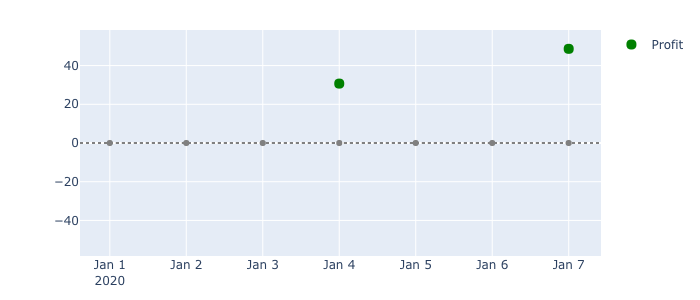

In [46]:
portfolio['a'].positions.plot_pnl().show_png()

In [47]:
print(portfolio['a'].positions.winning.pnl)
print(portfolio.positions.winning.pnl)

%timeit big_portfolio.positions.winning.pnl

2020-01-01          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-04    30.693069
2020-01-05          NaN
2020-01-06          NaN
2020-01-07    48.654054
Name: a, dtype: float64
                    a   b          c   d
2020-01-01        NaN NaN        NaN NaN
2020-01-02        NaN NaN  96.039604 NaN
2020-01-03        NaN NaN        NaN NaN
2020-01-04  30.693069 NaN        NaN NaN
2020-01-05        NaN NaN        NaN NaN
2020-01-06        NaN NaN        NaN NaN
2020-01-07  48.654054 NaN        NaN NaN
75.9 ms ± 3.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
print(portfolio['a'].positions.losing.pnl)
print(portfolio.positions.losing.pnl)

%timeit big_portfolio.positions.losing.pnl

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
2020-01-06   NaN
2020-01-07   NaN
Name: a, dtype: float64
             a          b         c         d
2020-01-01 NaN        NaN       NaN       NaN
2020-01-02 NaN        NaN       NaN       NaN
2020-01-03 NaN        NaN       NaN       NaN
2020-01-04 NaN -15.983027       NaN       NaN
2020-01-05 NaN        NaN       NaN -1.980198
2020-01-06 NaN -18.134357       NaN       NaN
2020-01-07 NaN        NaN -1.940986 -0.970493
71.3 ms ± 4.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [49]:
print(portfolio['a'].positions.total_pnl)
print(portfolio.positions.total_pnl)

%timeit big_portfolio.positions.total_pnl

79.34712283109499
a    79.347123
b   -34.117383
c    94.098618
d    -2.950691
dtype: float64
35.4 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
print(portfolio['a'].positions.winning.total_pnl)
print(portfolio.positions.winning.total_pnl)

%timeit big_portfolio.positions.winning.total_pnl

79.34712283109499
a    79.347123
b     0.000000
c    96.039604
d     0.000000
dtype: float64
75.5 ms ± 3.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [51]:
print(portfolio['a'].positions.losing.total_pnl)
print(portfolio.positions.losing.total_pnl)

%timeit big_portfolio.positions.losing.total_pnl

0.0
a     0.000000
b   -34.117383
c    -1.940986
d    -2.950691
dtype: float64
74.6 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
print(portfolio['a'].positions.avg_pnl)
print(portfolio.positions.avg_pnl)

%timeit big_portfolio.positions.avg_pnl

39.673561415547496
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
34 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [53]:
print(portfolio['a'].positions.winning.avg_pnl)
print(portfolio.positions.winning.avg_pnl)

%timeit big_portfolio.positions.winning.avg_pnl

39.673561415547496
a    39.673561
b          NaN
c    96.039604
d          NaN
dtype: float64
96.8 ms ± 22.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [54]:
print(portfolio['a'].positions.losing.avg_pnl)
print(portfolio.positions.losing.avg_pnl)

%timeit big_portfolio.positions.losing.avg_pnl

nan
a          NaN
b   -17.058692
c    -1.940986
d    -1.475346
dtype: float64
75.2 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [55]:
print(portfolio['a'].positions.returns)
print(portfolio.positions.returns)

%timeit big_portfolio.positions.returns

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    0.306931
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    0.372277
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02       NaN       NaN  0.960396       NaN
2020-01-03       NaN       NaN       NaN       NaN
2020-01-04  0.306931 -0.159830       NaN       NaN
2020-01-05       NaN       NaN       NaN -0.019802
2020-01-06       NaN -0.215842       NaN       NaN
2020-01-07  0.372277       NaN -0.009901 -0.009901
29.3 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


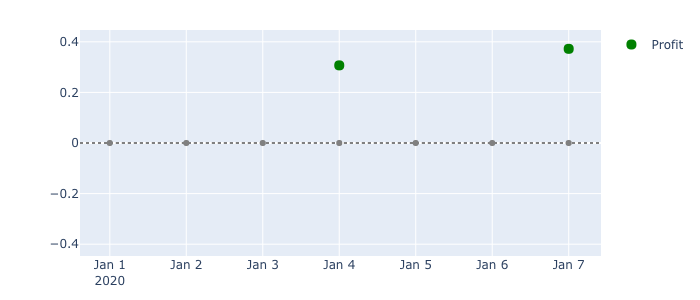

In [56]:
portfolio['a'].positions.plot_returns().show_png()

In [57]:
print(portfolio['a'].positions.winning.returns)
print(portfolio.positions.winning.returns)

%timeit big_portfolio.positions.winning.returns

2020-01-01         NaN
2020-01-02         NaN
2020-01-03         NaN
2020-01-04    0.306931
2020-01-05         NaN
2020-01-06         NaN
2020-01-07    0.372277
Name: a, dtype: float64
                   a   b         c   d
2020-01-01       NaN NaN       NaN NaN
2020-01-02       NaN NaN  0.960396 NaN
2020-01-03       NaN NaN       NaN NaN
2020-01-04  0.306931 NaN       NaN NaN
2020-01-05       NaN NaN       NaN NaN
2020-01-06       NaN NaN       NaN NaN
2020-01-07  0.372277 NaN       NaN NaN
70.8 ms ± 4.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [58]:
print(portfolio['a'].positions.losing.returns)
print(portfolio.positions.losing.returns)

%timeit big_portfolio.positions.losing.returns

2020-01-01   NaN
2020-01-02   NaN
2020-01-03   NaN
2020-01-04   NaN
2020-01-05   NaN
2020-01-06   NaN
2020-01-07   NaN
Name: a, dtype: float64
             a         b         c         d
2020-01-01 NaN       NaN       NaN       NaN
2020-01-02 NaN       NaN       NaN       NaN
2020-01-03 NaN       NaN       NaN       NaN
2020-01-04 NaN -0.159830       NaN       NaN
2020-01-05 NaN       NaN       NaN -0.019802
2020-01-06 NaN -0.215842       NaN       NaN
2020-01-07 NaN       NaN -0.009901 -0.009901
70.9 ms ± 2.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
print(portfolio['a'].positions.avg_return)
print(portfolio.positions.avg_return)

%timeit big_portfolio.positions.avg_return

0.3396039603960397
a    0.339604
b   -0.187836
c    0.475248
d   -0.014851
dtype: float64
36 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
print(portfolio['a'].positions.winning.avg_return)
print(portfolio.positions.winning.avg_return)

%timeit big_portfolio.positions.winning.avg_return

0.3396039603960397
a    0.339604
b         NaN
c    0.960396
d         NaN
dtype: float64
109 ms ± 33.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [61]:
print(portfolio['a'].positions.losing.avg_return)
print(portfolio.positions.losing.avg_return)

%timeit big_portfolio.positions.losing.avg_return

nan
a         NaN
b   -0.187836
c   -0.009901
d   -0.014851
dtype: float64
81.9 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
print(portfolio['a'].positions.win_rate)
print(portfolio.positions.win_rate)

%timeit big_portfolio.positions.win_rate

1.0
a    1.0
b    0.0
c    0.5
d    0.0
dtype: float64
66.8 ms ± 2.82 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [63]:
print(portfolio['a'].positions.loss_rate)
print(portfolio.positions.loss_rate)

%timeit big_portfolio.positions.loss_rate

0.0
a    0.0
b    1.0
c    0.5
d    1.0
dtype: float64
94.7 ms ± 37.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [64]:
print(portfolio['a'].positions.profit_factor)
print(portfolio.positions.profit_factor)

%timeit big_portfolio.positions.profit_factor

inf
a          inf
b     0.000000
c    49.479798
d     0.000000
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/portfolio/positions.py:260: RuntimeWarning:

divide by zero encountered in true_divide



183 ms ± 26.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [65]:
print(portfolio['a'].positions.expectancy)
print(portfolio.positions.expectancy)

%timeit big_portfolio.positions.expectancy

39.673561415547496
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
294 ms ± 20.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Equity

In [66]:
print(portfolio['a'].equity)
print(portfolio.equity)

%timeit big_portfolio.equity

2020-01-01    100.000000
2020-01-02    100.000000
2020-01-03     99.009901
2020-01-04    130.693069
2020-01-05    129.399079
2020-01-06    155.278894
2020-01-07    179.347123
Name: a, dtype: float64
                     a           b           c           d
2020-01-01  100.000000  100.000000   99.009901  100.000000
2020-01-02  100.000000  100.000000  196.039604  100.000000
2020-01-03   99.009901   99.009901  196.039604   99.009901
2020-01-04  130.693069   84.016973  196.039604   49.504950
2020-01-05  129.399079   83.185122  196.039604   98.019802
2020-01-06  155.278894   65.882617  196.039604   98.019802
2020-01-07  179.347123   65.882617  194.098618   97.049309
5.05 ms ± 146 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
print(portfolio['a'].total_profit)
print(portfolio.total_profit)

%timeit big_portfolio.total_profit

79.34712283109499
a    79.347123
b   -34.117383
c    94.098618
d    -2.950691
dtype: float64
10.5 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Returns

In [68]:
print(portfolio['a'].returns)
print(portfolio.returns)

%timeit big_portfolio.equity.pct_change()
%timeit big_portfolio.returns # numba helps a lot

2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.320000
2020-01-05   -0.009901
2020-01-06    0.200000
2020-01-07    0.155000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.000000 -0.009901
2020-01-04  0.320000 -0.151429  0.000000 -0.500000
2020-01-05 -0.009901 -0.009901  0.000000  0.980000
2020-01-06  0.200000 -0.208000  0.000000  0.000000
2020-01-07  0.155000  0.000000 -0.009901 -0.009901
303 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.9 ms ± 598 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
print(portfolio['a'].daily_returns)
print(portfolio.daily_returns)

%timeit big_portfolio.daily_returns

2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.320000
2020-01-05   -0.009901
2020-01-06    0.200000
2020-01-07    0.155000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.000000 -0.009901
2020-01-04  0.320000 -0.151429  0.000000 -0.500000
2020-01-05 -0.009901 -0.009901  0.000000  0.980000
2020-01-06  0.200000 -0.208000  0.000000  0.000000
2020-01-07  0.155000  0.000000 -0.009901 -0.009901
23.2 ms ± 616 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [70]:
print(portfolio['a'].annual_returns)
print(portfolio.annual_returns)

%timeit big_portfolio.annual_returns

2020-12-31    0.793471
Freq: A-DEC, Name: a, dtype: float64
                   a         b         c         d
2020-12-31  0.793471 -0.341174  0.960396 -0.029507
35.7 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [71]:
print(portfolio['a'].total_return)
print(portfolio.total_return)

%timeit big_portfolio.total_return

0.79347122831095
a    0.793471
b   -0.341174
c    0.940986
d   -0.029507
dtype: float64
6.97 ms ± 749 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Trades

In [72]:
print(portfolio['a'].trades)
print(portfolio.trades)

%timeit big_portfolio.trades

2020-01-01     0.000000
2020-01-02     0.000000
2020-01-03    33.003300
2020-01-04   -33.003300
2020-01-05    25.879816
2020-01-06     0.000000
2020-01-07   -25.879816
Name: a, dtype: float64
                    a          b           c          d
2020-01-01   0.000000   0.000000   99.009901   0.000000
2020-01-02   0.000000   0.000000  -99.009901   0.000000
2020-01-03  33.003300  14.144272    0.000000  49.504950
2020-01-04 -33.003300 -14.144272    0.000000   0.000000
2020-01-05  25.879816  16.637024    0.000000 -49.504950
2020-01-06   0.000000 -16.637024    0.000000   0.000000
2020-01-07 -25.879816   0.000000  194.098618  24.262327
9.08 ms ± 202 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


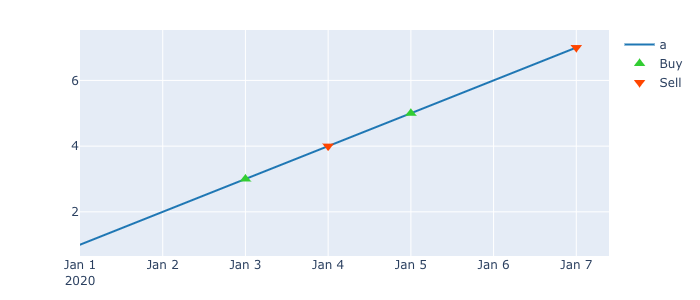

In [73]:
portfolio['a'].plot_trades().show_png()

In [74]:
print(portfolio['a'].trade_count)
print(portfolio.trade_count)

%timeit big_portfolio.trade_count

2
a    2
b    2
c    2
d    2
dtype: int64
13.2 ms ± 483 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Drawdown

In [75]:
print(portfolio['a'].drawdown)
print(portfolio.drawdown)

%timeit big_portfolio.drawdown

2020-01-01    0.000000
2020-01-02    0.000000
2020-01-03    0.009901
2020-01-04    0.000000
2020-01-05    0.009901
2020-01-06    0.000000
2020-01-07    0.000000
Name: a, dtype: float64
                   a         b         c         d
2020-01-01  0.000000  0.000000  0.000000  0.000000
2020-01-02  0.000000  0.000000  0.000000  0.000000
2020-01-03  0.009901  0.009901  0.000000  0.009901
2020-01-04  0.000000  0.159830  0.000000  0.504950
2020-01-05  0.009901  0.168149  0.000000  0.019802
2020-01-06  0.000000  0.341174  0.000000  0.019802
2020-01-07  0.000000  0.341174  0.009901  0.029507
20.8 ms ± 1.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
print(portfolio['a'].max_drawdown)
print(portfolio.max_drawdown)

%timeit big_portfolio.max_drawdown

0.00990099009901002
a    0.009901
b    0.341174
c    0.009901
d    0.504950
dtype: float64
24.8 ms ± 2.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Costs

In [77]:
print(portfolio['a'].total_fees_paid)
print(portfolio.total_fees_paid)

%timeit big_portfolio.total_fees_paid

5.415808907623429
a    5.415809
b    3.336087
c    4.911283
d    2.950691
dtype: float64
994 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [78]:
print(portfolio['a'].total_slippage_paid)
print(portfolio.total_slippage_paid)

%timeit big_portfolio.total_slippage_paid

0.0
a    0.0
b    0.0
c    0.0
d    0.0
dtype: float64
1.03 ms ± 51.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
print(portfolio['a'].total_costs)
print(portfolio.total_costs)

%timeit big_portfolio.total_costs

5.415808907623429
a    5.415809
b    3.336087
c    4.911283
d    2.950691
dtype: float64
2.33 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Financial risk and performance metrics

In [80]:
import empyrical

print(empyrical.cum_returns(portfolio['a'].returns.values))

print(portfolio['a'].cum_returns)
print(portfolio.cum_returns)

%timeit big_portfolio.cum_returns

[ 0.          0.         -0.00990099  0.30693069  0.29399079  0.55278894
  0.79347123]
2020-01-01         NaN
2020-01-02    0.000000
2020-01-03   -0.009901
2020-01-04    0.306931
2020-01-05    0.293991
2020-01-06    0.552789
2020-01-07    0.793471
Name: a, dtype: float64
                   a         b         c         d
2020-01-01       NaN       NaN       NaN       NaN
2020-01-02  0.000000  0.000000  0.980000  0.000000
2020-01-03 -0.009901 -0.009901  0.980000 -0.009901
2020-01-04  0.306931 -0.159830  0.980000 -0.504950
2020-01-05  0.293991 -0.168149  0.980000 -0.019802
2020-01-06  0.552789 -0.341174  0.980000 -0.019802
2020-01-07  0.793471 -0.341174  0.960396 -0.029507
25.3 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
print(empyrical.annual_return(portfolio['a'].returns.values, annualization=portfolio.ann_factor))

print(portfolio['a'].annualized_return)
print(portfolio.annualized_return)

%timeit big_portfolio.annualized_return

17263954475534.926
17263954475534.998
a    1.726395e+13
b   -1.000000e+00
c    1.793781e+15
d   -7.904448e-01
dtype: float64
35.4 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
print(empyrical.annual_volatility(portfolio['a'].returns.values, annualization=portfolio.ann_factor))

print(portfolio['a'].annualized_volatility)
print(portfolio.annualized_volatility)

%timeit big_portfolio.annualized_volatility

2.6353344465311017
2.6353344465311017
a    2.635334
b    1.760346
c    7.661944
d    9.265734
dtype: float64
21.3 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [83]:
print(empyrical.calmar_ratio(portfolio['a'].returns.values, annualization=portfolio.ann_factor))

print(portfolio['a'].calmar_ratio)
print(portfolio.calmar_ratio)

%timeit big_portfolio.calmar_ratio

1743659402029012.0
1743659402029013.8
a    1.743659e+15
b   -2.931057e+00
c    1.811719e+17
d   -1.565391e+00
dtype: float64
75.9 ms ± 17.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [84]:
print(empyrical.omega_ratio(portfolio['a'].returns.values, 
    annualization=portfolio.ann_factor, risk_free=portfolio.risk_free, required_return=portfolio.required_return))

print(portfolio['a'].omega_ratio)
print(portfolio.omega_ratio)

%timeit big_portfolio.omega_ratio

12.73535420662537


/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/stats.py:641: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/miniconda3/lib/python3.7/site-packages/empyrical/stats.py:642: RuntimeWarning:

invalid value encountered in less



12.73535420662537
a    12.735354
b     0.000000
c    15.843878
d     1.697999
dtype: float64
27.5 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [85]:
print(empyrical.sharpe_ratio(portfolio['a'].returns.values, 
    annualization=portfolio.ann_factor, risk_free=portfolio.risk_free))

print(portfolio['a'].sharpe_ratio)
print(portfolio.sharpe_ratio)

%timeit big_portfolio.sharpe_ratio

13.748515109956147
13.748515109956147
a    13.748515
b   -15.188840
c     7.230690
d     2.629209
dtype: float64
The slowest run took 6.88 times longer than the fastest. This could mean that an intermediate result is being cached.
50.1 ms ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [86]:
print(empyrical.downside_risk(portfolio['a'].returns.values, 
    annualization=portfolio.ann_factor, required_return=portfolio.required_return))

print(portfolio['a'].downside_risk)
print(portfolio.downside_risk)

%timeit big_portfolio.downside_risk

1.4419540622860902
1.4419540622860902
a    1.441954
b    3.508691
c    1.780505
d    4.960093
dtype: float64
The slowest run took 4.02 times longer than the fastest. This could mean that an intermediate result is being cached.
29 ms ± 18.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [87]:
print(empyrical.sortino_ratio(portfolio['a'].returns.values, 
    annualization=portfolio.ann_factor, required_return=portfolio.required_return))

print(portfolio['a'].sortino_ratio)
print(portfolio.sortino_ratio)

%timeit big_portfolio.sortino_ratio

2.3302479224571235
2.3302479224571235
a     2.330248
b   -16.989082
c    12.653331
d    -1.715748
dtype: float64
42 ms ± 4.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [88]:
print(empyrical.excess_sharpe(portfolio['a'].returns.values, portfolio['a'].factor_returns))

print(portfolio['a'].information_ratio)
print(portfolio.information_ratio)

%timeit big_portfolio.information_ratio

-1.0206278539385194
-1.0206278539385196
a   -1.020628
b   -2.311441
c   -0.413047
d   -0.846050
dtype: float64
46.9 ms ± 8.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
print(empyrical.beta(portfolio['a'].returns.values, 
    portfolio['a'].factor_returns, risk_free=portfolio.risk_free))

print(portfolio['a'].beta)
print(portfolio.beta)

%timeit big_portfolio.beta

nan
0.016075990416083683
a    0.016076
b   -0.052066
c    0.275825
d    0.222094
dtype: float64
30.3 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [90]:
print(empyrical.alpha(portfolio['a'].returns.values,
    portfolio['a'].factor_returns, risk_free=portfolio.risk_free))

print(portfolio['a'].alpha)
print(portfolio.alpha)

%timeit big_portfolio.alpha

nan
74440604878326.83
a    7.444060e+13
b   -9.999999e-01
c    2.760911e+09
d   -1.000000e+00
dtype: float64
The slowest run took 5.25 times longer than the fastest. This could mean that an intermediate result is being cached.
126 ms ± 78.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
print(empyrical.tail_ratio(portfolio['a'].returns.values))

print(portfolio['a'].tail_ratio)
print(portfolio.tail_ratio)

%timeit big_portfolio.tail_ratio

29.289999999999875
29.289999999999875
a    29.290000
b     0.000000
c    98.980000
d     1.947148
dtype: float64
58.5 ms ± 22.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
print(empyrical.value_at_risk(portfolio['a'].returns.values[1:], cutoff=portfolio.cutoff))

print(portfolio['a'].value_at_risk)
print(portfolio.value_at_risk)

%timeit big_portfolio.value_at_risk

-0.009900990099009903
-0.009900990099009905
a   -0.009901
b   -0.188200
c   -0.006436
d   -0.328465
dtype: float64
The slowest run took 4.46 times longer than the fastest. This could mean that an intermediate result is being cached.
65.7 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
print(empyrical.conditional_value_at_risk(portfolio['a'].returns.values, cutoff=portfolio.cutoff))

print(portfolio['a'].conditional_value_at_risk)
print(portfolio.conditional_value_at_risk)

%timeit big_portfolio.conditional_value_at_risk

-0.00990099009901002
-0.00990099009901002
a   -0.009901
b   -0.208000
c   -0.009901
d   -0.500000
dtype: float64
64.6 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [94]:
print(portfolio['a'].capture)
print(portfolio.capture)

%timeit big_portfolio.capture

3.0103257359682125e-45
a    3.010326e-45
b   -1.245903e-77
c    2.714835e-32
d   -3.904461e-60
dtype: float64
24 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
print(portfolio['a'].up_capture)
print(portfolio.up_capture)

%timeit big_portfolio.up_capture

3.0103257359682125e-45
a    3.010326e-45
b   -1.245903e-77
c    2.714835e-32
d   -3.904461e-60
dtype: float64
78.7 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [96]:
print(portfolio['a'].down_capture)
print(portfolio.down_capture)

%timeit big_portfolio.down_capture

nan
a   NaN
b   NaN
c   NaN
d   NaN
dtype: float64
21.5 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
print(portfolio['a'].skew)
print(portfolio.skew)

%timeit big_portfolio.skew

0.4621519716150829
a    0.462152
b   -0.817071
c    1.788460
d    1.043977
dtype: float64
150 ms ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
print(portfolio['a'].kurtosis)
print(portfolio.kurtosis)

%timeit big_portfolio.kurtosis

-1.2797047692491799
a   -1.279705
b   -1.172231
c    1.199300
d    0.373144
dtype: float64
145 ms ± 3.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Property traversal

In [13]:
portfolio.traverse_timeseries()

{'annual_returns': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Annual returns',
  'format': '%'},
 'cash': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Cash',
  'format': '$'},
 'cum_returns': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Cumulative returns',
  'format': '%'},
 'daily_returns': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Daily returns',
  'format': '%'},
 'drawdown': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Drawdown',
  'format': '%'},
 'equity': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Equity',
  'format': '$'},
 'fees_paid': {'property_cls': vectorbt.portfolio.props.timeseries_property,
  'name': 'Paid fees',
  'format': '$'},
 'positions': {'property_cls': vectorbt.portfolio.props.group_property,
  'name': 'Positions',
  'cls': vectorbt.portfolio.positions.Positions,
  'children': {'clo

In [14]:
portfolio.traverse_metrics()

{'alpha': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Annualized alpha',
  'format': '%'},
 'annualized_return': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Annualized return',
  'format': '%'},
 'annualized_volatility': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Annualized volatility',
  'format': '%'},
 'beta': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Beta',
  'format': '%'},
 'calmar_ratio': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Calmar ratio',
  'format': '%'},
 'capture': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Capture ratio',
  'format': '%'},
 'conditional_value_at_risk': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Conditional value at risk',
  'format': '$'},
 'down_capture': {'property_cls': vectorbt.portfolio.props.metric_property,
  'name': 'Capture ratio (negative)',
  'format': '%'